In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2

from fastai.vision.all import *
from fastai.vision import models
import torch

In [2]:
sz = 128
zoom = 60

In [3]:
path = '../input/preview_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

,fn,is_val,target_fn
0,input_60_128/1.npy,True,target_60_128/1.png
1,input_60_128/2.npy,False,target_60_128/2.png
2,input_60_128/3.npy,False,target_60_128/3.png
3,input_60_128/4.npy,False,target_60_128/4.png
4,input_60_128/5.npy,False,target_60_128/5.png


In [4]:
class BrightfieldImage(TensorImage):
    
    @classmethod
    def create(cls, fn):
        im = TensorImage(np.load(fn))
        
        mean = tensor([519.06234031, 518.50844388, 518.53247025, 518.56737158, 518.57572727, 518.62912976, 518.68634407])
        std = tensor([275.56237411, 270.05320819, 260.81917046, 249.73119559, 233.28654046, 216.3005945, 193.18197006])
        
        im = im * (256**2 - 1)
        im = (im - mean) / std
        
        return cls(im.permute(2,0,1))
    
    def show(self, ctx=None, **kwargs): 
        img = self
        if not isinstance(img, Tensor):
            t = tensor(img)
            t = t.permute(2,0,1)
        else: 
            t = img
            
        t = t.permute(1,2,0)
        
        # denormalize
        mean = tensor([519.06234031, 518.50844388, 518.53247025, 518.56737158, 518.57572727, 518.62912976, 518.68634407])
        std = tensor([275.56237411, 270.05320819, 260.81917046, 249.73119559, 233.28654046, 216.3005945, 193.18197006])
        t = (t * std) + mean
        t = t / (256**2 - 1)
        
        # convert to 3D PCA - these are pca components fractions for each brightfield channel
        red_comp = tensor([0.39423992, 0.43700847, 0.44657826, 0.42102395, 0.36548955, 0.30311383, 0.22681394])
        green_comp = tensor([-0.52929354, -0.39814758, -0.12413004, 0.16665499, 0.37310351, 0.44822793, 0.42193625])
        blue_comp = tensor([-0.49489557, -0.05811184, 0.43123788, 0.47214236, 0.08612177, -0.29430201, -0.49878477])
        
        h,w,c = t.shape
        t = t.view(-1,c).float()
        
        t = torch.stack([
            torch.matmul(t, red_comp),
            torch.matmul(t, green_comp),
            torch.matmul(t, blue_comp),
        ], dim=1)
        
        # normalize according to pca stats to better cover the full 0-1 range for visualization
        t = t / tensor([0.25,0.11,0.02])
        brighten_factor = 5
        t = t*brighten_factor
        t = t.view(h,w,-1)
        t = t.clamp(0.,1.).permute(2,0,1)
        
        return show_image(t, title='Brightfield', ctx=ctx, **kwargs)
    
class FluorescenceImage(TensorImage):
    @classmethod
    def create(cls, fn):
        im = TensorImage(cv2.imread(fn, -1).astype(np.float32))
        # normalize
        mean = tensor([327.79297103, 1548.88373241, 341.84451986])
        std = tensor([418.48723383, 1097.49263918, 131.44001168])
        im = (im - mean) / std
        
        return cls(im.permute(2,0,1))
    
    def show(self, ctx=None, **kwargs): 
        img = self
        if not isinstance(img, Tensor):
            t = tensor(img)
            t = t.permute(2,0,1)
        else: 
            t = img
            
        t = t.permute(1,2,0)
        
        # better cover the full 0-1 range for visualization
        t = (t + 2.) / 4.0
        t = t.clamp(0.,1.).permute(2,0,1)
        
        return show_image(t, title='Fluorescence', ctx=ctx, **kwargs)

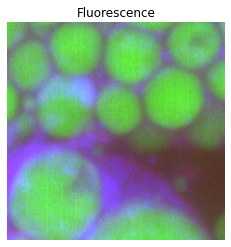

In [5]:
targ = FluorescenceImage.create(os.path.join(path, df.iloc[100].target_fn))
targ.show();

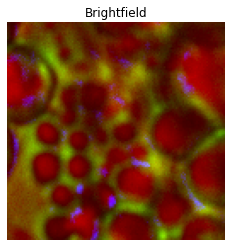

In [6]:
s = BrightfieldImage.create(os.path.join(path, df.iloc[25].fn))
s.show();

In [7]:
def BrightfieldImageBlock():
    return TransformBlock(type_tfms=BrightfieldImage.create, 
                          batch_tfms= [])

def FluorescenceImageBlock():
    return TransformBlock(type_tfms=FluorescenceImage.create, batch_tfms=[])

def get_xy_files(path):
    files = [os.path.join(path, fn) for fn in df.fn.values]
    targets = [os.path.join(path, fn) for fn in df.target_fn.values]
    return [[x,y] for x,y in zip(files, targets)]

def get_x(t): return t[0]
def get_y(t): return t[1]

splitter = FuncSplitter(lambda o: df[df.fn == str(o[0]).replace(path,'')].is_val.values[0])

In [8]:
dblock = DataBlock(blocks = (BrightfieldImageBlock, FluorescenceImageBlock),
                   get_items=get_xy_files,
                   get_x=get_x, get_y=get_y,
                   splitter = splitter,
                   item_tfms=[],)
                   #batch_tfms = )
dls = dblock.dataloaders(path, path='.', bs=4)

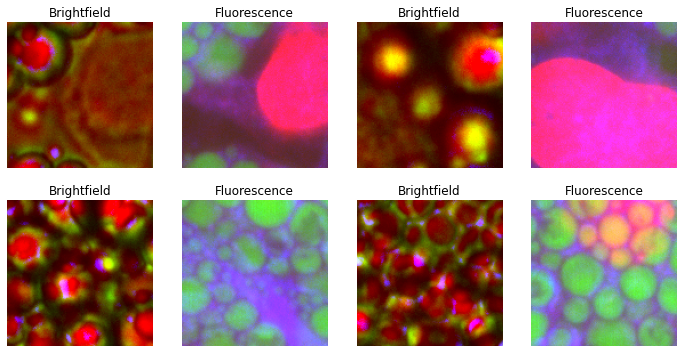

In [9]:
dls.show_batch()

In [10]:
xs, ys = dls.one_batch()

In [11]:
xs.shape

torch.Size([4, 7, 128, 128])

In [12]:
ys.shape

torch.Size([4, 3, 128, 128])

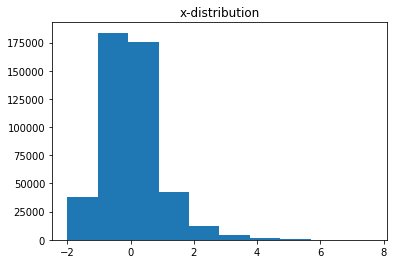

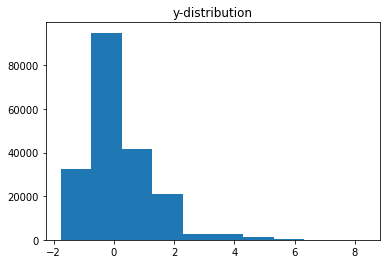

In [13]:
plt.hist(xs.cpu().numpy().ravel())
plt.title('x-distribution')
plt.show()

plt.hist(ys.cpu().numpy().ravel())
plt.title('y-distribution')
plt.show()

In [14]:
def resnet34_7chan(pretrained=True):
    resnet = models.resnet34(pretrained=pretrained)
    conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)
    if pretrained:
        w = resnet.conv1.weight
        conv1.weight = nn.Parameter(torch.cat((w,
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:])
              ),dim=1))
    resnet.conv1 = conv1
    return resnet

In [15]:
learn = unet_learner(dls, resnet34_7chan, n_out=3, loss_func=MSELossFlat(axis=1))

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.5848931980144698e-06)

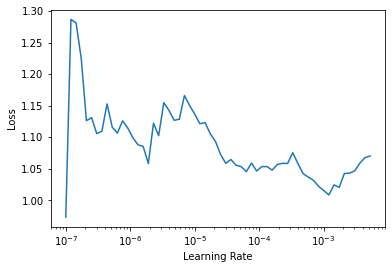

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.906960,0.642216,00:06


epoch,train_loss,valid_loss,time
0,0.789621,0.540822,00:07
1,0.740637,0.662719,00:06
2,0.745804,0.627802,00:06
3,0.679044,0.535897,00:06
4,0.619847,0.466593,00:06
5,0.584986,0.474821,00:06
6,0.552399,0.446919,00:06
7,0.550044,0.445855,00:06


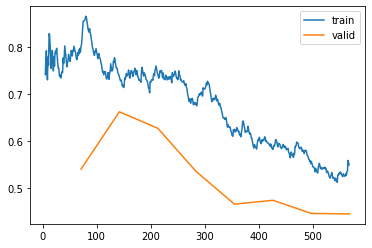

In [18]:
learn.recorder.plot_loss()

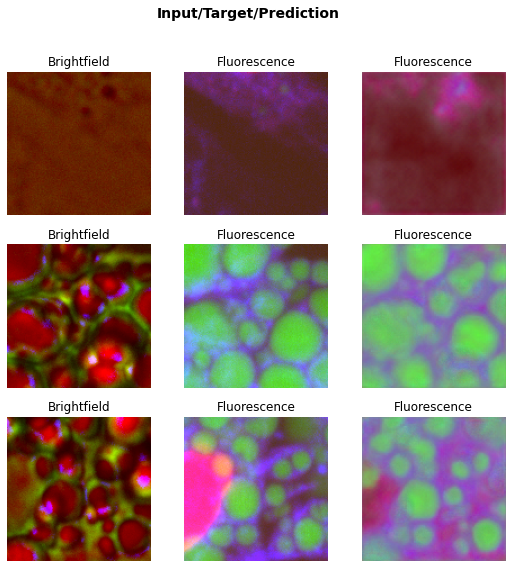

In [19]:
learn.show_results()

In [20]:
learn.fit_flat_cos(10, lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.558852,0.478641,00:06
1,0.541182,0.476309,00:06
2,0.519116,0.623102,00:06
3,0.482116,0.431458,00:06
4,0.417872,0.456784,00:06
5,0.368010,0.418514,00:06
6,0.310993,0.476809,00:06
7,0.284165,0.442067,00:06
8,0.242426,0.417384,00:06
9,0.207404,0.428554,00:06


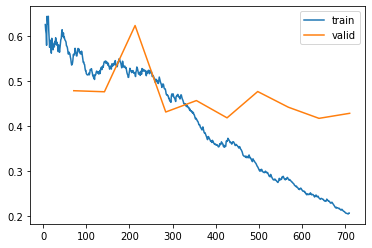

In [21]:
learn.recorder.plot_loss()

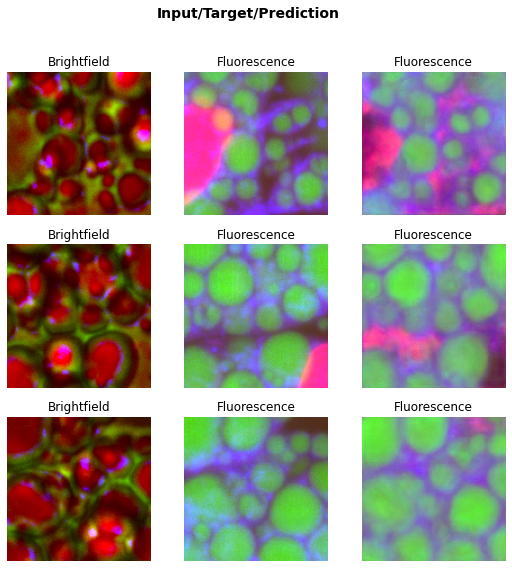

In [22]:
learn.show_results()

## Perceptual loss

In [15]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks).cuda()
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)).cuda()
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)).cuda()
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [16]:
learn = unet_learner(
    dls, 
    resnet34_7chan, 
    n_out=3, 
    loss_func=VGGPerceptualLoss()
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/joni/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/joni/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0002290867705596611)

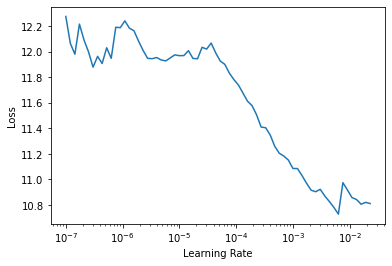

In [17]:
learn.lr_find()

In [18]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,9.693441,9.358830,00:14


epoch,train_loss,valid_loss,time
0,8.742950,8.296370,00:14
1,8.426975,7.722803,00:14
2,8.169946,7.401006,00:14
3,7.910914,7.125688,00:14
4,7.603254,6.913329,00:14
5,7.471386,6.847842,00:14
6,7.184213,6.698882,00:14
7,7.019423,6.774596,00:14


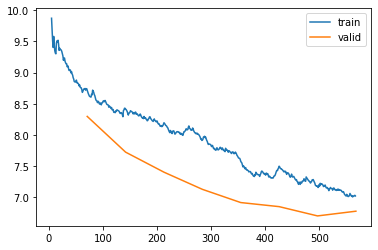

In [19]:
learn.recorder.plot_loss()

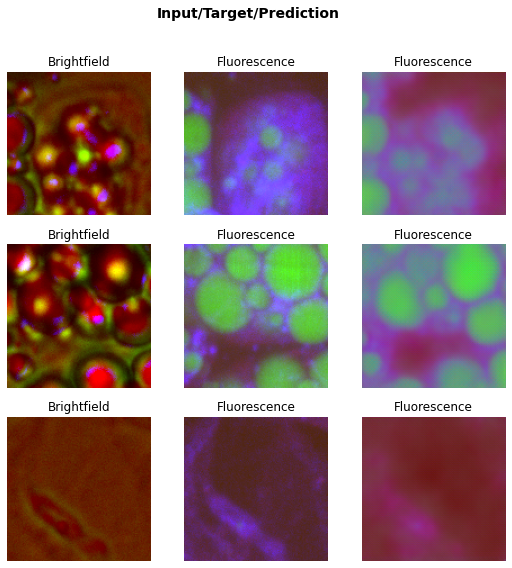

In [20]:
learn.show_results()

In [21]:
learn.fit_flat_cos(10, lr=1e-4)

epoch,train_loss,valid_loss,time
0,7.047092,6.825622,00:14
1,6.951016,6.726788,00:14
2,6.800042,6.781251,00:14
3,6.735610,6.653433,00:14
4,6.640244,6.813941,00:14
5,6.457942,6.701210,00:14
6,6.373331,6.617084,00:14
7,6.182343,6.617877,00:14
8,6.101491,6.672415,00:14
9,5.989614,6.651546,00:14


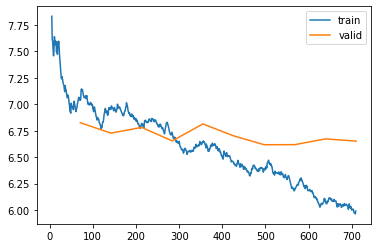

In [22]:
learn.recorder.plot_loss()

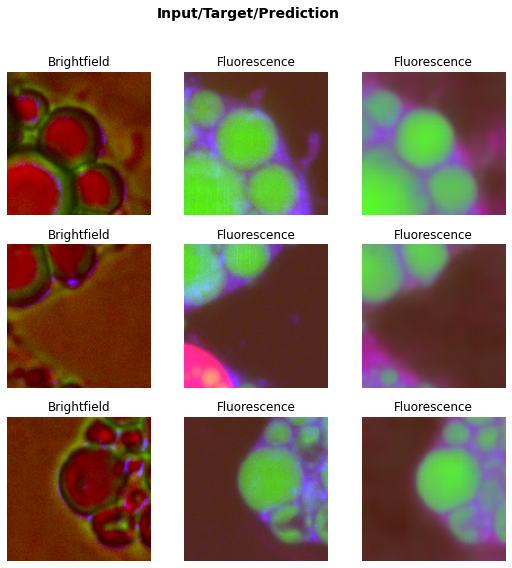

In [24]:
learn.show_results()

## Edgeloss

In [17]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

def get_thin_kernels(start=0, end=360, step=45):
        k_thin = 3  # actual size of the directional kernel
        # increase for a while to avoid interpolation when rotating
        k_increased = k_thin + 2

        # get 0° angle directional kernel
        thin_kernel_0 = np.zeros((k_increased, k_increased))
        thin_kernel_0[k_increased // 2, k_increased // 2] = 1
        thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

        # rotate the 0° angle directional kernel to get the other ones
        thin_kernels = []
        for angle in range(start, end, step):
            (h, w) = thin_kernel_0.shape
            # get the center to not rotate around the (0, 0) coord point
            center = (w // 2, h // 2)
            # apply rotation
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

            # get the k=3 kerne
            kernel_angle = kernel_angle_increased[1:-1, 1:-1]
            is_diag = (abs(kernel_angle) == 1)      # because of the interpolation
            kernel_angle = kernel_angle * is_diag   # because of the interpolation
            thin_kernels.append(kernel_angle)
        return thin_kernels

class CannyFilter(nn.Module):
    def __init__(self,
                 k_gaussian=3,
                 mu=0,
                 sigma=1,
                 k_sobel=3,
                 use_cuda=True):
        super(CannyFilter, self).__init__()
        # device
        self.device = 'cuda' if use_cuda else 'cpu'

        # gaussian

        gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False).to(self.device)
        with torch.no_grad():
            self.gaussian_filter.weight[:] = torch.from_numpy(gaussian_2D).to(self.device)
        self.gaussian_filter.requires_grad=False

        # sobel

        sobel_2D = get_sobel_kernel(k_sobel)
        self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False).to(self.device)
        with torch.no_grad():
            self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D).to(self.device)
        self.sobel_filter_x.requires_grad=False


        self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False).to(self.device)
        with torch.no_grad():
            self.sobel_filter_y.weight[:] = torch.from_numpy(sobel_2D.T).to(self.device)
        self.sobel_filter_y.requires_grad=False


        # thin

        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False).to(self.device)
        with torch.no_grad():
            self.directional_filter.weight[:, 0] = torch.from_numpy(directional_kernels).to(self.device)
        self.directional_filter.requires_grad=False

        # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    padding=1,
                                    bias=False).to(self.device)
        with torch.no_grad():
            self.hysteresis.weight[:] = torch.from_numpy(hysteresis).to(self.device)
        self.hysteresis.requires_grad=False


    def forward(self, img, low_threshold=None, high_threshold=None, hysteresis=False):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W), requires_grad=False).to(self.device)
        grad_x = torch.zeros((B, 1, H, W), requires_grad=False).to(self.device)
        grad_y = torch.zeros((B, 1, H, W), requires_grad=False).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W), requires_grad=False).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W), requires_grad=False).to(self.device)

        # gaussian

        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        # thick edges

        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180 # convert to degree
        grad_orientation = torch.round(grad_orientation / 45) * 45  # keep a split by 45

        # thin edges

        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])

            # get the local maximum pixels for the angle
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)

            # apply non maximum suppression
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds

        if low_threshold is not None:
            low = thin_edges > low_threshold

            if high_threshold is not None:
                high = thin_edges > high_threshold
                # get black/gray/white only
                thin_edges = low * 0.5 + high * 0.5

                if hysteresis:
                    # get weaks and check if they are high or not
                    weak = (thin_edges == 0.5) * 1
                    weak_is_high = (self.hysteresis(thin_edges) > 1) * weak
                    thin_edges = high * 1 + weak_is_high * 1
            else:
                thin_edges = low * 1


        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges

In [36]:
canny = CannyFilter(k_gaussian=5)

In [37]:
blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges = canny(
    ys[0].view(1,3,128,128),
    low_threshold=0.1,
    high_threshold=0.3,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

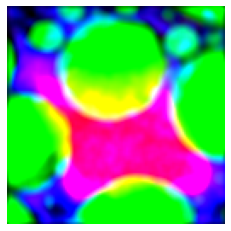

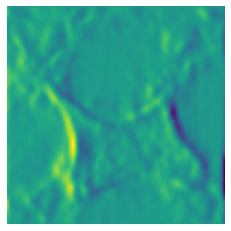

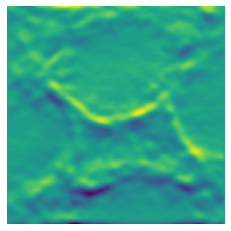

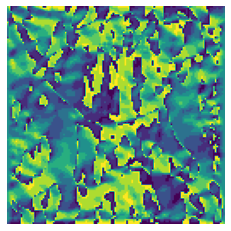

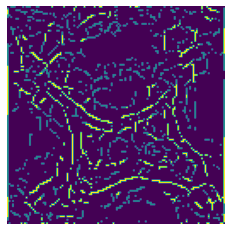

In [38]:
TensorImage(blurred[0]).show()
TensorImage(grad_x[0]).show()
TensorImage(grad_y[0]).show()
TensorImage(grad_orientation[0]).show()
TensorImage(thin_edges[0]).show()

In [42]:
class EdgeLoss(torch.nn.Module):
    def __init__(self):
        super(EdgeLoss, self).__init__()
        self.canny = CannyFilter(k_gaussian=5)
        self.mse = MSELossFlat(axis=1)
        #self.percloss = VGGPerceptualLoss()

    def forward(self, input, target):
        #percloss = self.percloss(input, target)
        mse_loss = self.mse(input, target)
        low_threshold=0.1
        high_threshold=0.3
        
        # returns: blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges
        _,input_x,input_y,_,_,input_canny = self.canny(input, low_threshold=low_threshold, high_threshold=high_threshold)
        _,target_x,target_y,_,_,target_canny = self.canny(target, low_threshold=low_threshold, high_threshold=high_threshold)
        #edge_loss = self.mse(input_canny, target_canny)
        edge_loss = self.mse(input_canny, target_canny)
        #edge_loss = self.mse(input_x, target_x) + self.mse(input_y, target_y)
        
        #print(mse_loss, edge_loss)
        
        loss = 2 * edge_loss + mse_loss #percloss
        #loss = edge_loss
        return loss

In [43]:
learn = unet_learner(
    dls, 
    resnet34_7chan, 
    n_out=3, 
    loss_func=EdgeLoss()
)

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.5848931980144698e-06)

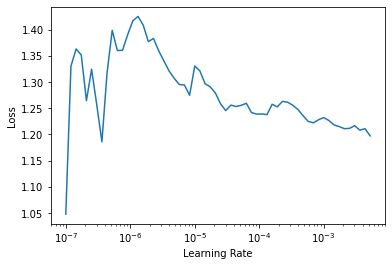

In [44]:
learn.lr_find()

In [45]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,1.067523,0.903606,00:06


epoch,train_loss,valid_loss,time
0,0.890044,0.732361,00:07
1,0.863215,0.644529,00:06
2,0.839069,0.639666,00:07
3,0.805040,0.611143,00:06
4,0.785297,0.599011,00:06
5,0.731582,0.585809,00:06
6,0.700116,0.554590,00:06
7,0.657668,0.551313,00:06


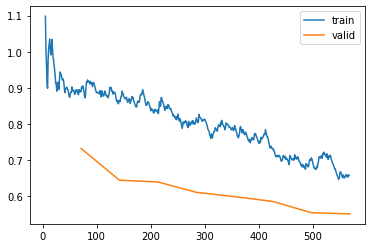

In [46]:
learn.recorder.plot_loss()

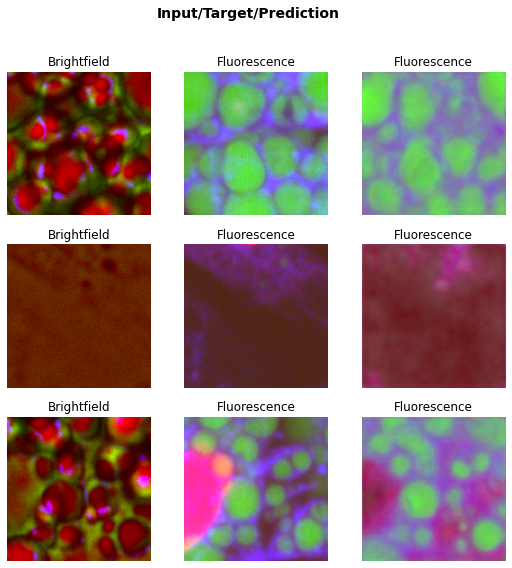

In [47]:
learn.show_results()

In [48]:
learn.fit_flat_cos(10, lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.697510,0.613350,00:06
1,0.670619,0.535338,00:06
2,0.643197,0.545958,00:06
3,0.611106,0.555789,00:06
4,0.548784,0.525348,00:06
5,0.496785,0.568484,00:06
6,0.458784,0.537419,00:06
7,0.408943,0.560512,00:06
8,0.377060,0.563381,00:06
9,0.345679,0.544725,00:07


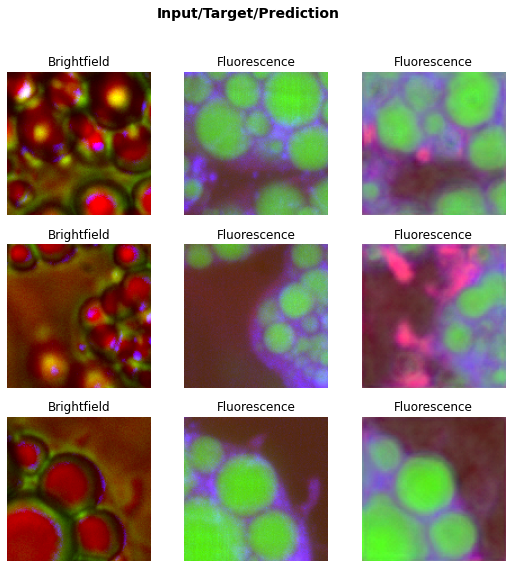

In [49]:
learn.show_results()